In [ ]:
import torch
import os
import json
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import matplotlib.pyplot as plt


In [12]:
def load_dataset(csv_dir, json_path):
    # 1. JSON読み込みと辞書化
    with open(json_path, 'r') as f:
        json_data = json.load(f)
    
    rgb_dict = {item["filename"]: item["real_rgb"] for item in json_data}

    # 2. 特徴量とラベルの蓄積
    X_list = []
    y_list = []

    for filename in os.listdir(csv_dir):
        if not filename.endswith("_masked.csv"):
            continue

        base_id = filename.replace("_masked.csv", "")  # 例: 8D5U5524

        if base_id not in rgb_dict:
            print(f"Warning: {base_id} not in JSON, skipping")
            continue

        csv_path = os.path.join(csv_dir, filename)
        df = pd.read_csv(csv_path, header=None)

        # 特徴量は1行と仮定してflatten
        features = df.values.flatten()

        X_list.append(features)

        # real_rgbからr, gの比率を計算
        R, G, B = rgb_dict[base_id]
        total = R + G + B if R + G + B != 0 else 1e-6  # 0割防止

        r_ratio = R / total
        g_ratio = G / total

        y_list.append([r_ratio, g_ratio])

    # DataFrameに変換
    X = pd.DataFrame(X_list)
    y = pd.DataFrame(y_list, columns=["r_ratio", "g_ratio"])


    return X, y

In [13]:
#load_datasetのテスト
X, y = load_dataset(csv_dir="../histpre/", json_path="../real_rgb.json")

print(X.shape)  # 特徴量の数 x サンプル数
print(y.head()) # RGBのターゲット値

print(X.iloc[0])  # 1番目のサンプルの特徴量


(5, 1324)
    r_ratio   g_ratio
0  0.311968  0.423124
1  0.305714  0.425317
2  0.366901  0.446526
3  0.354669  0.435492
4  0.358548  0.439233
0       0
1       0
2       0
3       0
4       0
       ..
1319    0
1320    0
1321    0
1322    0
1323    0
Name: 0, Length: 1324, dtype: int64


In [14]:
class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()  # 出力を0〜1に制限

    def forward(self, x):
        # 活性化関数は使用せず、線形変換のみ
        h = self.hidden(x)  # 隠れ層（線形のみ）
        out = self.output(h)  # 出力層（線形）
        out = self.sigmoid(out)  # 0〜1に制限
        return out


In [15]:

def euclidean_loss(pred, target):
    return torch.sqrt(((pred - target) ** 2).sum(dim=1)).mean()

In [16]:
def mse_chromaticity_loss(pred, target, eps=1e-8):
    # クロマティシティ座標に変換：r = R/(R+G+B), g = G/(R+G+B)
    pred_sum = pred.sum(dim=1, keepdim=True) + eps
    target_sum = target.sum(dim=1, keepdim=True) + eps

    pred_chroma = pred[:, :2] / pred_sum  # (r, g)
    target_chroma = target[:, :2] / target_sum

    loss = ((pred_chroma - target_chroma) ** 2).mean()
    return loss


In [17]:
def train_one_epoch(model, loader, optimizer, loss_fn):
    model.train()  # モデルを訓練モードに設定
    total_loss = 0.0

    for X_batch, y_batch in loader:
        optimizer.zero_grad()               # 勾配をリセット
        pred = model(X_batch)               # 順伝播
        loss = loss_fn(pred, y_batch)       # 損失計算
        loss.backward()                     # 逆伝播
        optimizer.step()                    # パラメータ更新

        total_loss += loss.item()           # 損失を蓄積

    average_loss = total_loss / len(loader)  # バッチ数で割る
    return average_loss

In [18]:
def evaluate(model, loader, loss_fn):
    model.eval()  # 評価モードに切り替え
    total_loss = 0.0

    with torch.no_grad():  # 勾配を計算しない（メモリ節約＆高速化）
        for X_batch, y_batch in loader:
            pred = model(X_batch)
            loss = loss_fn(pred, y_batch)
            total_loss += loss.item()

    average_loss = total_loss / len(loader)
    return average_loss

In [19]:

def main():
    # 1. データ読み込み
    X_train_df, y_train_df = load_dataset('../histpre/', '../real_rgb.json')
    X_val_df, y_val_df = load_dataset('../histpre', '../real_rgb.json')

    # 2. Tensorに変換
    X_train = torch.tensor(X_train_df.values, dtype=torch.float32)
    y_train = torch.tensor(y_train_df[["r_ratio", "g_ratio"]].values, dtype=torch.float32)
    X_val = torch.tensor(X_val_df.values, dtype=torch.float32)
    y_val = torch.tensor(y_val_df[["r_ratio", "g_ratio"]].values, dtype=torch.float32)


    # 3. TensorDataset作成
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)

    # 4. DataLoader作成
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # 5. モデル定義
    model = MLPModel(input_dim=X_train.shape[1], hidden_dim=256, output_dim=2)
    # SGDオプティマイザで学習
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    #　損失関数はクロマティシティ座標のMSE
    loss_fn = mse_chromaticity_loss

    # 6. 学習ループ
    num_epochs = 5

    # 学習記録用リスト
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
    
        train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn)
        val_loss = evaluate(model, val_loader, loss_fn)
        print(f"Epoch {epoch+1:02d}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

        # ログ保存
        train_losses.append(train_loss)
        val_losses.append(val_loss)

    # 7. モデル保存
    torch.save(model.state_dict(), 'mlp_model.pth')
   

    # 8. 学習曲線の可視化
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


Epoch 01: Train Loss = 0.0045, Val Loss = 0.0040
Epoch 02: Train Loss = 0.0040, Val Loss = 0.0036
Epoch 03: Train Loss = 0.0036, Val Loss = 0.0032
Epoch 04: Train Loss = 0.0032, Val Loss = 0.0028
Epoch 05: Train Loss = 0.0028, Val Loss = 0.0025


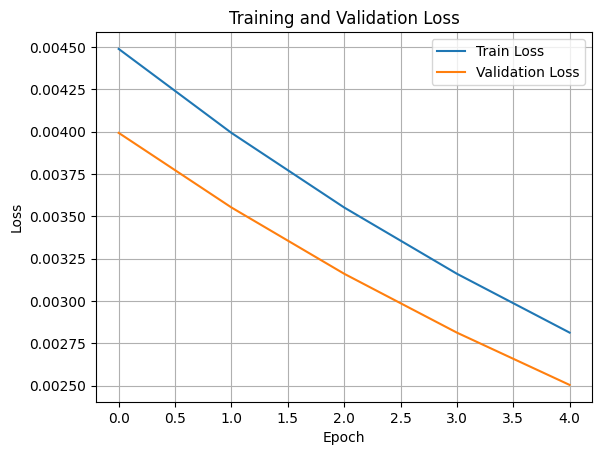

In [20]:
if __name__ == "__main__":
    main()

In [22]:
from pathlib import Path

BASE_DIR = Path(__file__).resolve().parents[1]  # ../../
HISTPRE_DIR = BASE_DIR / "data" / "histpre"
print(BASE_DIR)
# → /your_project （config.py の2階層上）
print(HISTPRE_DIR)
# → /your_project/data/histpre


NameError: name '__file__' is not defined